In [1]:
import os
from time import time

import matplotlib.pyplot as plt
import numpy as np
import Optimizer
import torch
from torch import nn
from torchvision import datasets, transforms

%matplotlib inline

In [2]:
def view_classify(img, ps):
    """Function for viewing an image and it's predicted classes"""
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis("off")
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title("Class Probability")
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()


In [3]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [4]:
# Download and load the training data
if not os.path.exists("tmp_dataset"):
    trainset = datasets.MNIST("tmp_dataset/train", download=True, train=True, transform=transform)
    valset = datasets.MNIST("tmp_dataset/val", download=True, train=False, transform=transform)
else:
    trainset = datasets.MNIST("tmp_dataset/train", download=False, train=True, transform=transform)
    valset = datasets.MNIST("tmp_dataset/val", download=False, train=False, transform=transform)

In [5]:
# Create a dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


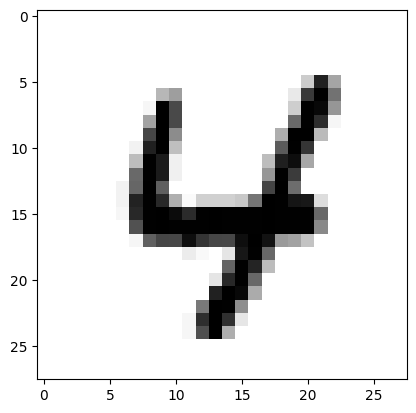

In [6]:
# Obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap="gray_r");

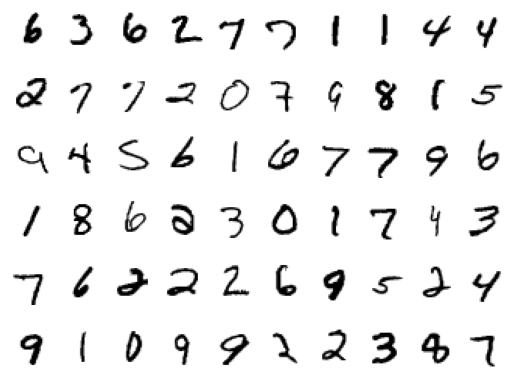

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis("off")
    plt.imshow(images[index].numpy().squeeze(), cmap="gray_r")

In [8]:
# define the network architecture
input_size = 784
hidden_sizes = [512, 128]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(
    nn.Linear(input_size, hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[0], hidden_sizes[1]),
    nn.ReLU(),
    nn.Linear(hidden_sizes[1], output_size),
    nn.LogSoftmax(dim=1),
)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [9]:
# Define the loss
criterion = nn.NLLLoss()

# get one batch of data
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

# Forward pass, get the logits
logps = model(images)  # log probabilities
loss = criterion(logps, labels)  # calculate the Negative Log Likelihood (NLL) loss

In [10]:
print("Before backward pass: \n", model[0].weight.grad)
loss.backward()
print("After backward pass: \n", model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-2.1795e-03, -2.1795e-03, -2.1795e-03,  ..., -2.1795e-03,
         -2.1795e-03, -2.1795e-03],
        [-1.0639e-04, -1.0639e-04, -1.0639e-04,  ..., -1.0639e-04,
         -1.0639e-04, -1.0639e-04],
        [-4.5379e-05, -4.5379e-05, -4.5379e-05,  ..., -4.5379e-05,
         -4.5379e-05, -4.5379e-05],
        ...,
        [-9.7234e-06, -9.7234e-06, -9.7234e-06,  ..., -9.7234e-06,
         -9.7234e-06, -9.7234e-06],
        [-1.9386e-03, -1.9386e-03, -1.9386e-03,  ..., -1.9386e-03,
         -1.9386e-03, -1.9386e-03],
        [-2.2719e-03, -2.2719e-03, -2.2719e-03,  ..., -2.2719e-03,
         -2.2719e-03, -2.2719e-03]])


In [11]:
# used for collecting the losses for every epoch to display the training progress
vals = []
trains = []

In [12]:
# defining the stochastic gradient descent optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

# init our optimizer
optimizer = Optimizer.GD(learning_rate=0.001)


In [13]:
# set the start time
time0 = time()
epochs = 30


for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # batch training pass
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        model = optimizer.zero_grad(model)

        output = model(images)
        loss = criterion(output, labels)

        # This is where the model learns by backpropagating
        # calculate the partial derivatives of the loss function with respect to the weights & biases
        loss.backward()

        # optimizes (update) its weights
        # new_parm = old_parm - learning_rate * parm_grad
        model = optimizer.step(model)

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss / len(trainloader)))
        trains.append(running_loss / len(trainloader))

    val_loss = 0
    for images, labels in valloader:
        images = images.view(images.shape[0], -1)

        # Validation pass
        output = model(images)
        loss = criterion(output, labels)

        val_loss += loss.item()
    else:
        print("Epoch {} - Validation loss: {}".format(e, val_loss / len(valloader)))
        vals.append(val_loss / len(valloader))

print("\nTraining Time (in minutes) =", (time() - time0) / 60)

Epoch 0 - Training loss: 2.1893456177924997
Epoch 0 - Validation loss: 2.042404701755305
Epoch 1 - Training loss: 1.8299317395509178
Epoch 1 - Validation loss: 1.5596561257246953
Epoch 2 - Training loss: 1.3094221846635408
Epoch 2 - Validation loss: 1.0616890541307487
Epoch 3 - Training loss: 0.9196764646308508
Epoch 3 - Validation loss: 0.7755484710073774
Epoch 4 - Training loss: 0.7096106255931387
Epoch 4 - Validation loss: 0.6229926921000146
Epoch 5 - Training loss: 0.5954097948475942
Epoch 5 - Validation loss: 0.5378064790349097
Epoch 6 - Training loss: 0.5267842574350869
Epoch 6 - Validation loss: 0.483716360133165
Epoch 7 - Training loss: 0.48134585550980274
Epoch 7 - Validation loss: 0.4438912353128385
Epoch 8 - Training loss: 0.44867746584387475
Epoch 8 - Validation loss: 0.41744282376614344
Epoch 9 - Training loss: 0.42414996652270176
Epoch 9 - Validation loss: 0.39576110784794877
Epoch 10 - Training loss: 0.4050189507668461
Epoch 10 - Validation loss: 0.3815832972336727
Epoch

In [14]:
# optimized -> 7.615 min
# oldvals = vals
# oldtrains = trains

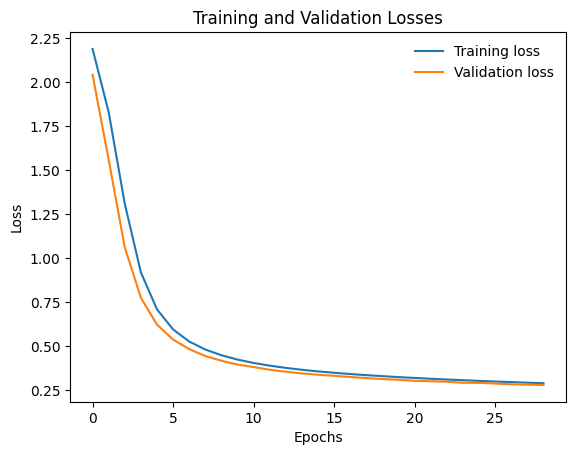

In [16]:
# plot the losses
tr = np.array(trains)
vl = np.array(vals)
point_num = -1
plt.plot(tr[:point_num], label="Training loss")
plt.plot(vl[:point_num], label="Validation loss")

# plt.plot(oldtrains[:point_num], label='Old Training loss')
# plt.plot(oldvals[:point_num], label='Old Validation loss')

# print the last loss values for training and validation on the plot
# plt.text(point_num, tr[point_num], f'{tr[point_num]:.2f}')
# plt.text(point_num, vl[point_num], f'{vl[point_num]:.2f}')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")

plt.legend(frameon=False)
plt.savefig("training_loss.svg", dpi=300)

Predicted Digit = 4


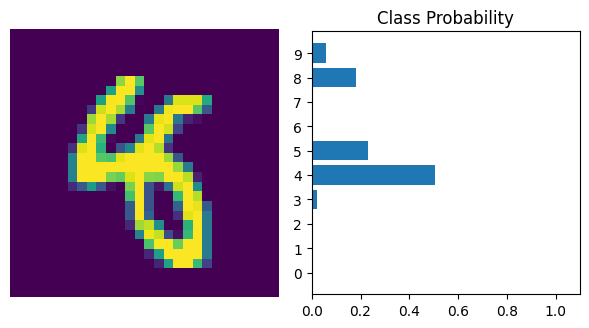

In [17]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

plt.savefig("prediction.svg", dpi=300)

In [18]:
correct_count, all_count = 0, 0
for images, labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img)

        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if true_label == pred_label:
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count / all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9205


In [18]:
# torch.save(model, './original_model.pt')